In [ ]:
# @title
from IPython.display import display, HTML

display(HTML("""
<div style="
    display: flex;
    flex-direction: column;
    justify-content: center;
    align-items: center;
    height: 90vh;
    text-align: center;
">

  <h1 style="margin-bottom: 40px;">
    Formula One Race Outcome Prediction
  </h1>

  <p style="font-size: 18px; margin-bottom: 80px;">
    Exploratory Data Analysis and Feature Engineering
  </p>

  <p style="font-size: 16px; margin-bottom: 40px;">
    Sara Alsiyat - Qifan Yang - Boqi Niu
  </p>

  <p style="font-size: 16px; margin-bottom: 10px;">
    Final Project - Milestone 2
  </p>

  <p style="font-size: 16px; margin-bottom: 80px;">
    MSDS 422: Practical Machine Learning
  </p>

  <p style="font-size: 16px;">
    February 2026
  </p>

</div>

<div style="page-break-after: always;"></div>
"""))

# Introduction

This notebook presents the exploratory data analysis (EDA) for the project Machine Learning-Based Prediction of Formula One Race Outcomes. The focus of this analysis is to understand the structure, content, and quality of historical Formula One data before applying machine learning techniques. The project examines whether information about drivers, constructors, circuits, and race context can help explain why some drivers finish within the top 10 positions of a race while others do not.

The dataset used in this notebook is a publicly available Formula One World Championship dataset obtained from Kaggle, covering races from 1950 to recent seasons. The data is provided in multiple relational tables, including race results, qualifying performance, driver and constructor information, race status, and circuit details. The unit of analysis is at the driver–race level, where each observation represents a driver’s outcome in a specific race. This structure allows the analysis of both individual performance and broader contextual factors.

The purpose of the exploratory data analysis is to examine key variables, identify patterns and relationships, and detect data quality issues such as missing values or class imbalance. In particular, this notebook explores the distribution of top-10 finishes, the relationship between qualifying position and race outcome, and the role of constructor effects. The insights gained from this analysis provide a foundation for data preparation and feature selection in later stages of the project. Overall, this notebook supports a data-driven approach to understanding Formula One race performance and prepares the dataset for subsequent machine learning modeling.

# Environment Setup

This section imports the Python libraries required for data loading, analysis, and visualization.

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import stats
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')


nu_purple = "#4E2A84"
nu_gray = "#E6E6E6"
nu_light_purple = "#B6ACD1"
nu_dark_gray = "#716C6B"
missing_cmap = ListedColormap([nu_light_purple, nu_gray])


NU_COLORS = {
    'purple': '#4E2A84',           # Northwestern Purple (Primary)
    'light_purple': '#836EAA',     # Light Purple
    'dark_purple': '#401F68',      # Dark Purple
    'white': '#FFFFFF',
    'black': '#000000',
    'gray': '#717171',
    'light_gray': '#D8D6D6',
    'accent_green': '#58B947',     # Accent color
    'accent_blue': '#0D47A1',      # Accent color
    'accent_orange': '#F77F00',    # Accent color
    'accent_red': '#DC143C'        # Accent color
}

# Custom color palette for visualizations
NU_PALETTE = [
    NU_COLORS['purple'],
    NU_COLORS['accent_orange'],
    NU_COLORS['accent_blue'],
    NU_COLORS['accent_green'],
    NU_COLORS['light_purple'],
    NU_COLORS['accent_red'],
    NU_COLORS['gray']
]

# Set matplotlib style with Northwestern colors
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = NU_COLORS['purple']
plt.rcParams['axes.labelcolor'] = NU_COLORS['black']
plt.rcParams['xtick.color'] = NU_COLORS['gray']
plt.rcParams['ytick.color'] = NU_COLORS['gray']
plt.rcParams['text.color'] = NU_COLORS['black']
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlecolor'] = NU_COLORS['purple']

# Set seaborn style
sns.set_palette(NU_PALETTE)
sns.set_style("whitegrid")

## Helper Functions
I create helper functions used for data cleaning, feature engineering, visualization, and model evaluation. Defining these functions early improves code organization and avoids repetition later in the notebook.

In [2]:
# @title


def nu_style_table(df, caption=None):
    """Apply Northwestern-styled formatting to a pandas DataFrame."""
    return (
        df.style
        .set_table_styles(
            [
                {
                    "selector": "table",
                    "props": [
                        ("width", "100%"),
                        ("margin", "0 auto"),
                        ("border-collapse", "collapse"),
                    ],
                },
                {
                    "selector": "caption",
                    "props": [
                        ("caption-side", "top"),
                        ("font-weight", "bold"),
                        ("font-size", "14px"),
                        ("text-align", "center"),
                        ("white-space", "nowrap"),
                        ("padding-bottom", "6px"),
                    ],
                },
                {
                    "selector": "th",
                    "props": [
                        ("background-color", nu_purple),
                        ("color", "white"),
                        ("font-weight", "bold"),
                        ("text-align", "center"),
                        ("padding", "6px"),
                    ],
                },
                {
                    "selector": "td",
                    "props": [
                        ("background-color", nu_gray),
                        ("text-align", "center"),
                        ("color", "black"),  # Changed the td color to black for visibility
                        ("padding", "6px"),
                    ],
                },
            ]
        )
        .set_caption(caption if caption else "")
    )

merge_log = []
def log_step(step_name, df_obj):
  merge_log.append({
      "Step": step_name,
      "Rows": f"{df_obj.shape[0]:,}",
      "Columns": df_obj.shape[1]
      })

## Load Dataset

The following tables are loaded for the exploratory analysis.  
These tables provide the core information needed to analyze race outcomes and performance.

In [3]:
# Download latest version
path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")

# Load relevant tables
races = pd.read_csv(f"{path}/races.csv")
results = pd.read_csv(f"{path}/results.csv")
drivers = pd.read_csv(f"{path}/drivers.csv")
constructors = pd.read_csv(f"{path}/constructors.csv")
circuits = pd.read_csv(f"{path}/circuits.csv")
qualifying = pd.read_csv(f"{path}/qualifying.csv")
status = pd.read_csv(f"{path}/status.csv")
driver_standings = pd.read_csv(f"{path}/driver_standings.csv")
constructor_standings = pd.read_csv(f"{path}/constructor_standings.csv")

Using Colab cache for faster access to the 'formula-1-world-championship-1950-2020' dataset.


## Create a Dataset Summary Table

In [4]:
datasets = {
    "Races": races,
    "Results": results,
    "Drivers": drivers,
    "Constructors": constructors,
    "Circuits": circuits,
    "Qualifying": qualifying,
    "Status": status,
    "Driver Standings": driver_standings,
    "Constructor Standings": constructor_standings
}

summary_rows = []

for name, df in datasets.items():
    summary_rows.append({
        "Dataset": name,
        "Rows": f"{df.shape[0]:,}",
        "Columns": df.shape[1]
    })

dataset_summary = pd.DataFrame(summary_rows)

nu_style_table(
    dataset_summary,
    caption="Summary of Formula One Dataset Tables"
)

,Dataset,Rows,Columns
0,Races,"1,125",18
1,Results,"26,759",18
2,Drivers,861,9
3,Constructors,212,5
4,Circuits,77,9
5,Qualifying,"10,494",9
6,Status,139,2
7,Driver Standings,"34,863",7
8,Constructor Standings,"13,391",7


The datasets summary table shows that `Results` is the largest core performance table which has 26,759 rows. This makes it suitable as the driver–race–result backbone for our analysis. `Races` has 1,125 rows which provides the season/round context. `Qualifying` has 10,494 rows which adds pre-race performance signals that can be joined at the driver–race level. datasets `Drivers` (861 rows), `Constructors` (212 rows), and `Circuits` (77 rows) are relatively small. They primarily contribute stable descriptive attributes such as identity, nationality, and location that enable various grouping possibilities and feature engineerings. The standings tables (`Driver Standings` with 34,863 rows and `Constructor Standings` with 13,391 rows) are larger records that capture points accumulation over time and can support season-progress features if aligned by race date/round. Overall, this table shows sufficient historical coverage and data richness to support both exploratory comparisons and predictive modeling at the driver–race level.

## Dataset Integration

This section summarizes the process of merging multiple Formula One datasets into a single driver–race level table. The table below shows how the dataset dimensions change after each merge step.

In [5]:
# Start with results as the base table (driver–race level)
df = results.copy()
log_step("Start: Results (base table)", df)

# Merge with races
df = df.merge(
    races[['raceId', 'year', 'round', 'circuitId', 'name', 'date']],
    on='raceId',
    how='left',
    suffixes=('', '_race')
)
log_step("Merge: Races", df)

# Merge with drivers
df = df.merge(
    drivers[['driverId', 'driverRef', 'code', 'forename', 'surname', 'dob', 'nationality']],
    on='driverId',
    how='left',
    suffixes=('', '_driver')
)
df['driver_name'] = df['forename'] + ' ' + df['surname']
log_step("Merge: Drivers", df)

# Merge with constructors
df = df.merge(
    constructors[['constructorId', 'constructorRef', 'name', 'nationality']],
    on='constructorId',
    how='left',
    suffixes=('', '_constructor')
)

# Rename to avoid confusion between race name and constructor name
df.rename(columns={'name': 'race_name', 'name_constructor': 'constructor_name'}, inplace=True)
log_step("Merge: Constructors", df)

# Merge with circuits
df = df.merge(
    circuits[['circuitId', 'circuitRef', 'name', 'location', 'country', 'lat', 'lng', 'alt']],
    on='circuitId',
    how='left',
    suffixes=('', '_circuit')
)

# Rename circuit name safely
if 'name_circuit' in df.columns:
    df.rename(columns={'name_circuit': 'circuit_name'}, inplace=True)
elif 'name' in df.columns:
    df.rename(columns={'name': 'circuit_name'}, inplace=True)

log_step("Merge: Circuits", df)

# Merge with qualifying data
df = df.merge(
    qualifying[['raceId', 'driverId', 'constructorId', 'position']],
    on=['raceId', 'driverId', 'constructorId'],
    how='left',
    suffixes=('', '_qual')
)

# Rename qualifying position safely
if 'position_qual' in df.columns:
    df.rename(columns={'position_qual': 'qualifying_position'}, inplace=True)
else:
    df.rename(columns={'position': 'qualifying_position'}, inplace=True)

log_step("Merge: Qualifying", df)

# Merge with status
df = df.merge(
    status[['statusId', 'status']],
    on='statusId',
    how='left'
)
log_step("Merge: Status", df)

# Create merge summary table
merge_summary = pd.DataFrame(merge_log)

# Display styled table
nu_style_table(
    merge_summary,
    caption="Dataset Merge Steps and Resulting Dimensions"
)

,Step,Rows,Columns
0,Start: Results (base table),"26,759",18
1,Merge: Races,"26,759",23
2,Merge: Drivers,"26,759",30
3,Merge: Constructors,"26,759",33
4,Merge: Circuits,"26,759",40
5,Merge: Qualifying,"26,759",41
6,Merge: Status,"26,759",42


To support our desired driver–race level analysis, we integrated the relational F1 tables from the original data source into a single dataset using `Results` as the base as it already represents one record per driver per race. Each merge operation was performed as a left join because this preserves the full set of race outcomes which is 26,759 rows while also incrementally adding the contextual and identity attributes into it. The integration process increased the feature space from 18 to 42 columns without changing the row count. This indicates that joins we performed were primarily one-to-one or many-to-one, for example each result maps to exactly one race, driver, constructor, circuit, and status. We also applied renaming operations such as separating `race_name`, `constructor_name`, and `circuit_name` to avoid column collisions and improve interpretability. Note that merging qualifying information introduces a meaningful pre-race signal (`qualifying_position`) while retaining missingness where qualifying records are unavailable, which can be addressed during later data cleaning and feature engineering. Overall, our dataset integration produces a consistent table that captures race context, participant identity, team effects, and outcome status at the correct unit of analysis.

## Target Variable Definition

This section defines the primary target variable used in this project, as well as additional outcome indicators that support exploratory analysis. The table below summarizes the distribution of each target variable across the dataset.

In [6]:
# Primary target: Top-10 finish (binary)
df['top10_finish'] = (df['positionOrder'] <= 10).astype(int)

# Additional outcome indicators
df['points_finish'] = (df['points'] > 0).astype(int)
df['podium_finish'] = (df['positionOrder'] <= 3).astype(int)
df['dnf'] = df['status'].apply(
    lambda x: 0 if ('Finished' in str(x) or '+' in str(x)) else 1
)

# Create summary table
target_summary = pd.DataFrame({
    "Target Variable": [
        "Top-10 Finish",
        "Points Finish",
        "Podium Finish",
        "Did Not Finish (DNF)"
    ],
    "Positive Cases": [
        df['top10_finish'].sum(),
        df['points_finish'].sum(),
        df['podium_finish'].sum(),
        df['dnf'].sum()
    ],
    "Percentage (%)": [
        f"{df['top10_finish'].mean()*100:.1f}",
        f"{df['points_finish'].mean()*100:.1f}",
        f"{df['podium_finish'].mean()*100:.1f}",
        f"{df['dnf'].mean()*100:.1f}"
    ]
})

# Display styled table
nu_style_table(
    target_summary,
    caption="Distribution of Target and Outcome Variables"
)

,Target Variable,Positive Cases,Percentage (%)
0,Top-10 Finish,11321,42.3
1,Points Finish,8170,30.5
2,Podium Finish,3397,12.7
3,Did Not Finish (DNF),11598,43.3


The primary prediction target for this project is a binary `Top-10 finish` indicator, which reflects whether a driver finished within the top ten positions in a race. This definition aligns with modern Formula One’s points-scoring system and represents a meaningful threshold of competitive success. More specifically, a driver can only score points in a race if they finish in top 10. Across the full dataset, 42.3% of driver–race observations result in a Top-10 finish, which indicates a moderately balanced target variable that is suitable for classification modeling. We also constructed complementary indicators for points finishes, podium finishes, and did-not-finish (DNF) events to provide additional context for race outcomes. As expected, podium finishes are relatively rare which is only 12.7% while DNFs occur in a substantial share of races (43.3%). These observations reflect the long historical span of the data, the higher mechanical failure rates in earlier eras, and the hard-to-predict nature of Formula 1 races. These auxiliary outcome variables support richer exploratory analysis and may inform feature engineering while the `Top-10 finish` variable serves as the central modeling objective.

# Exploratory Data Analysis

This section provides a high-level overview of the integrated Formula One dataset used in this project. It summarizes the temporal coverage, key entities in the data, and the presence of missing values. This overview helps establish context and assess data quality before deeper exploratory analysis.

## Dataset overview summary

In [7]:
overview_summary = pd.DataFrame({
    "Metric": [
        "Time Period",
        "Total Races",
        "Total Drivers",
        "Total Constructors",
        "Total Circuits"
    ],
    "Value": [
        f"{df['year'].min()} – {df['year'].max()}",
        f"{df['raceId'].nunique():,}",
        f"{df['driverId'].nunique():,}",
        f"{df['constructorId'].nunique():,}",
        f"{df['circuitId'].nunique():,}"
    ]
})

nu_style_table(
    overview_summary,
    caption="High-Level Overview of the Formula One Dataset"
)

,Metric,Value
0,Time Period,1950 – 2024
1,Total Races,"1,125"
2,Total Drivers,861
3,Total Constructors,211
4,Total Circuits,77


Our dataset provides historical coverage of Formula One racing from 1950 to 2024. It enables analysis across multiple eras of race regulations (rules), technologies, and competitive structures. In total, the integrated dataset captures 1,125 races and participation from 861 drivers and 211 constructors across 77 different circuits. It highlights both rich sample size and diversity in competitive contexts. This supports robust exploratory comparisons such as across teams, circuits, and time periods analysis. It also provides sufficient data volume for machine learning, while also signaling the need to account for temporal shifts such as changes in race formats, points systems, and reliability. These may influence outcome distributions across decades.

## Missing Values Analysis
This subsection examines missing values across the dataset to identify variables that may require special handling during data preparation. Only variables with at least one missing value are shown.

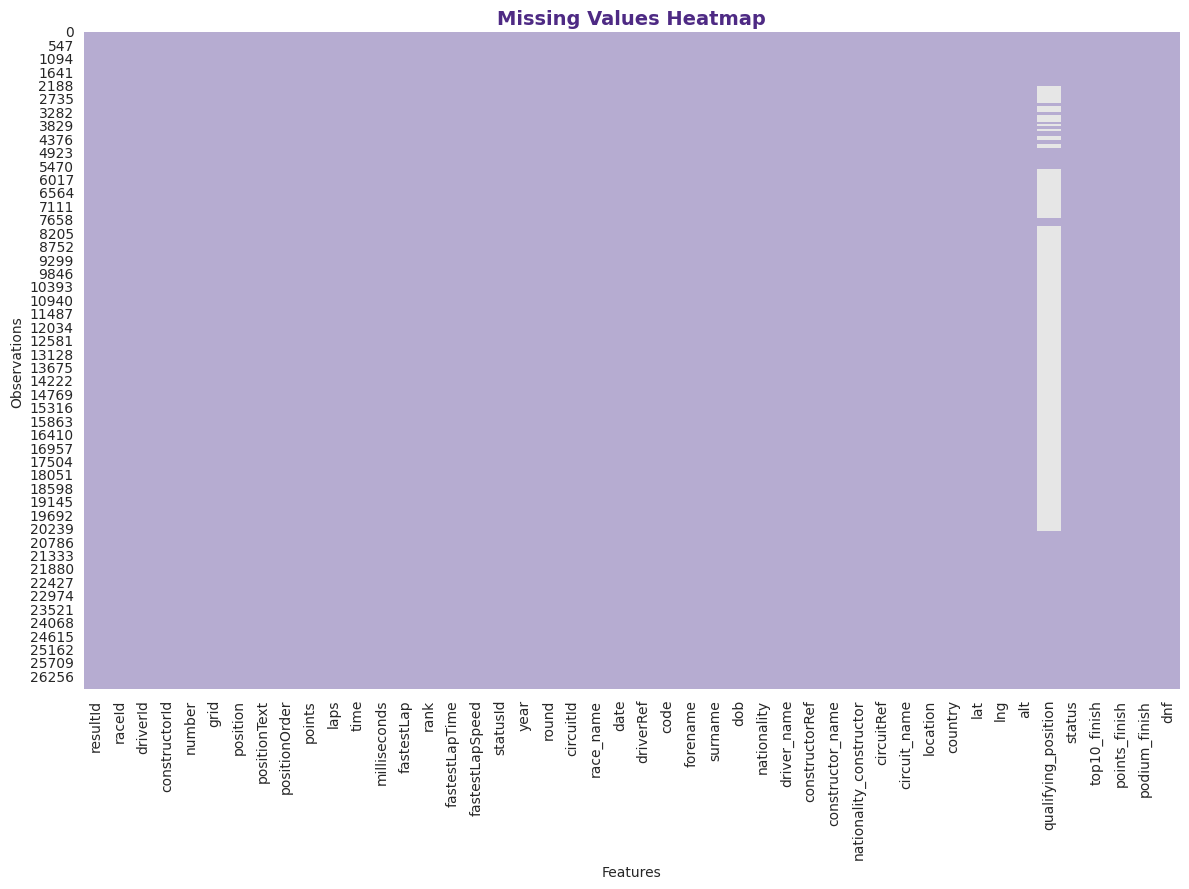

In [8]:
plt.figure(figsize=(12, 9))
sns.heatmap(
    df.isnull(),
    cbar=False,
    cmap=missing_cmap
)

plt.title("Missing Values Heatmap")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.tight_layout()
plt.show()

In [9]:
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = (
    pd.DataFrame({
        "Feature": missing.index,
        "Missing Count": missing.values,
        "Percentage (%)": missing_pct.values
    })
    .query("`Missing Count` > 0")
    .sort_values("Missing Count", ascending=False)
    .reset_index(drop=True)
)

nu_style_table(
    missing_df,
    caption="Variables with Missing Values"
)

,Feature,Missing Count,Percentage (%)
0,qualifying_position,16275,60.820658


Our missing values check shows that the integrated dataset is largely complete. Missingness is concentrated almost entirely in a single feature: `qualifying_position`. About 60.8% of observations lack qualifying position, which is consistent with historical coverage differences as qualifying records are not available for many earlier seasons and some race entries. The missing values heatmap confirms this pattern visually that missing values appear as a prominent vertical band under the qualifying column rather than being widespread across many variables. This finding is significant for modeling because qualifying is likely a strong predictor of Top-10 outcomes. However, its high missing rate means it cannot be used very easily across the full 1950–2024 timeframe. In later data preparation, we will need to handle this missingness systematically such as restricting modeling to seasons with qualifying data, adding a “missing qualifying” indicator, or using alternative starting position variables such as `grid` to avoid bias and ensure consistent feature availability.

## Target Variable Distribution and Context Over Time
This section presents exploratory visualizations that describe how top-10 finishes, DNFs, and related outcomes vary over time. These plots provide context for the target variable and help identify broad patterns in race outcomes before model development.

### Top-10 Finishes Over Time (Count and Rate)

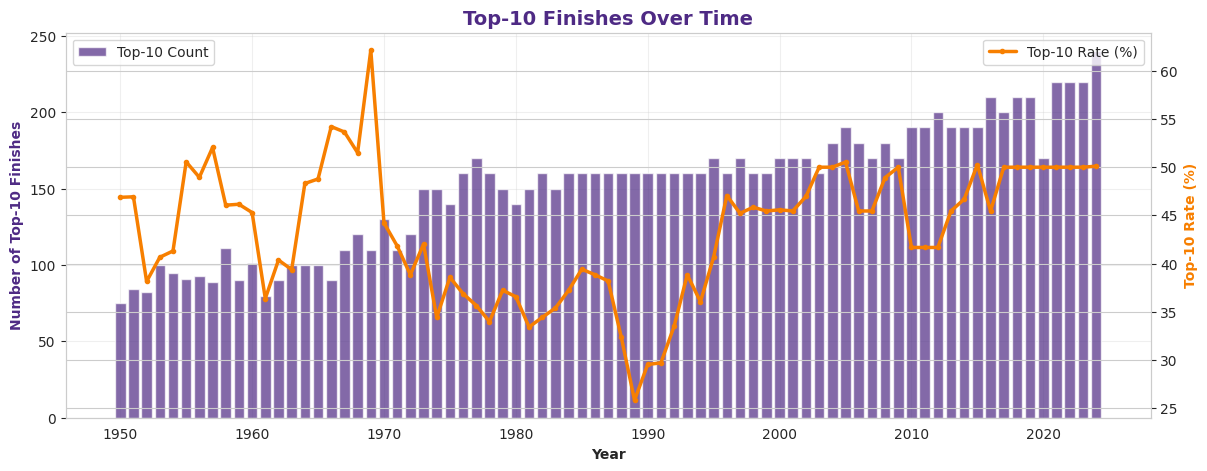

In [10]:
yearly_top10 = (
    df.groupby('year')
      .agg(top10_count=('top10_finish', 'sum'),
           top10_rate=('top10_finish', 'mean'),
           num_races=('raceId', 'nunique'))
      .reset_index()
)

fig, ax = plt.subplots(figsize=(14, 5))

ax.bar(yearly_top10['year'], yearly_top10['top10_count'],
       color=NU_COLORS['purple'], alpha=0.7, label='Top-10 Count')

ax2 = ax.twinx()
ax2.plot(yearly_top10['year'], yearly_top10['top10_rate'] * 100,
         color=NU_COLORS['accent_orange'], linewidth=2.5,
         marker='o', markersize=3, label='Top-10 Rate (%)')

ax.set_title("Top-10 Finishes Over Time", fontsize=14, fontweight='bold', color=NU_COLORS['purple'])
ax.set_xlabel("Year", fontweight='bold')
ax.set_ylabel("Number of Top-10 Finishes", fontweight='bold', color=NU_COLORS['purple'])
ax2.set_ylabel("Top-10 Rate (%)", fontweight='bold', color=NU_COLORS['accent_orange'])

ax.grid(True, alpha=0.3)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

The Top-10 trend shows two distinct dynamics, which are volume and baseline difficulty. The purple bars indicate Top-10 counts generally rise over time. This trend is expected because the sport expands as more races per season and more total driver-race entries naturally produce more Top-10 finishes in absolute terms. In contrast, the orange line which indicates Top-10 rate varies substantially across eras and then stabilizes closer to a steady band in modern seasons being roughly around the high 40s to 50% range. Its larger swings in earlier decades likely reflect structural changes in Formula One over time such as differing field sizes, race formats, and reliability issues. This means that the same “Top-10” label does not represent an identical competitive baseline across all years. This temporal drift suggests that modeling should account for era effects. We may need to include year/season features or use time-based splits so the classifier learns patterns that generalize to recent seasons rather than overfitting older contexts.

### Top-10 Rate by Starting Grid Position

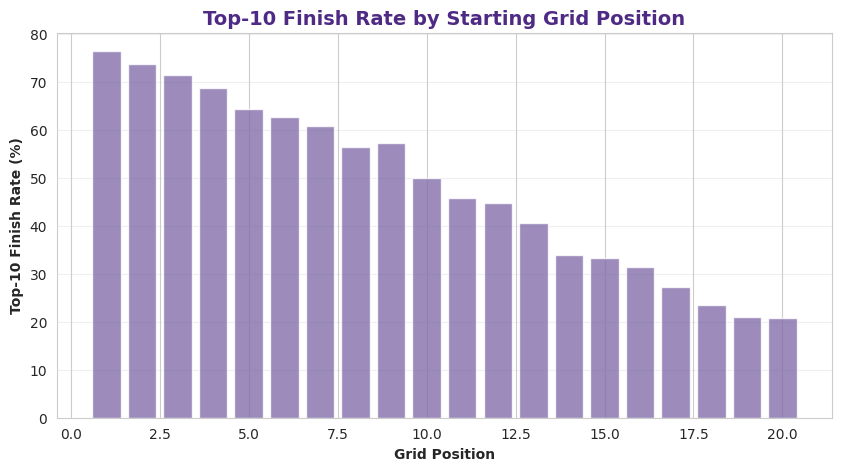

In [11]:
grid_top10 = df.groupby('grid')['top10_finish'].mean() * 100

grid_positions = list(range(1, min(21, len(grid_top10) + 1)))
grid_rates = grid_top10.loc[grid_positions]

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(grid_positions, grid_rates,
       color=NU_COLORS['light_purple'], alpha=0.8)

ax.set_title("Top-10 Finish Rate by Starting Grid Position", fontsize=14, fontweight='bold', color=NU_COLORS['purple'])
ax.set_xlabel("Grid Position", fontweight='bold')
ax.set_ylabel("Top-10 Finish Rate (%)", fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.show()

The Top-10 finish rate by starting grid position visualization shows a clear and nearly monotonic decline as grid position moves backward. Drivers starting on the front row have a Top-10 probability above 70%, while those starting around the middle of the grid (positions 10–12) have a Top-10 probability of around 45–50%, and drivers starting near the back of the grid (positions 18–20) have a Top-10 probability of roughly 20%. This strong gradient highlights starting position as one of the most influential determinants of race outcome. This reflects both underlying car performance and the tactical advantage of track position. From a modeling perspective, this result confirms that grid and qualifying-related features have substantial predictive power. However, it also suggests diminishing marginal returns at the front of the grid and a steep penalty for poor starting positions. These are patterns that non-linear models may capture more effectively than linear ones.

### Correlation Between Outcome Indicators

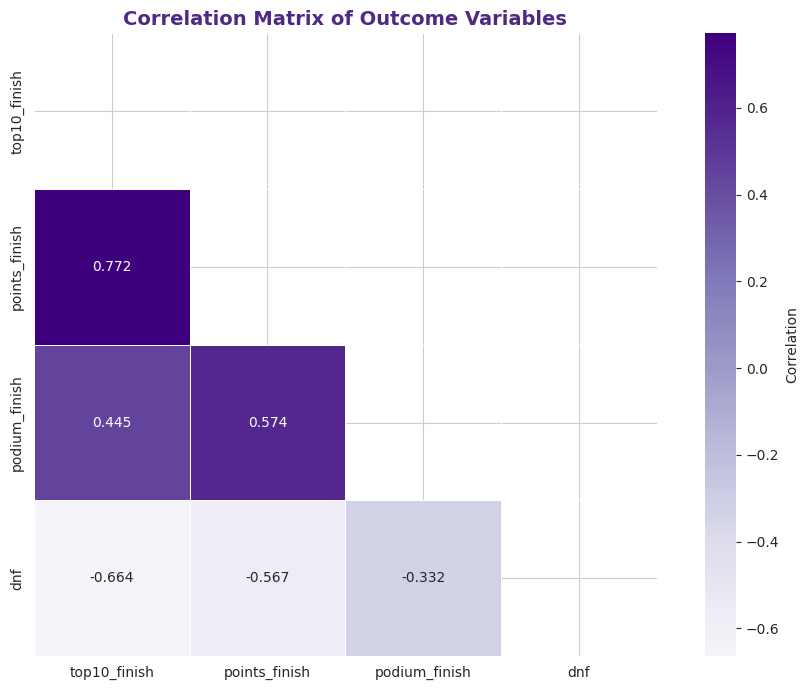

In [12]:
# Correlation matrix for outcome variables
corr_matrix = df[['top10_finish', 'points_finish', 'podium_finish', 'dnf']].corr()

fig, ax = plt.subplots(figsize=(10, 7))

# Mask upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.3f',
    cmap='Purples',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation'},
    ax=ax
)

ax.set_title(
    'Correlation Matrix of Outcome Variables',
    fontsize=14,
    fontweight='bold',
    color=NU_COLORS['purple']
)

plt.tight_layout()
plt.show()

The correlation matrix highlights strong and expected relationships among the different race outcome indicators. It also confirms that they capture distinct aspects of performance. Top-10 finishes and points finishes are highly correlated (ρ ≈ 0.77). This is expected and it reflects the close alignment between finishing in the Top-10 and scoring championship points under modern F1 rules. Podium finishes show a moderate correlation with Top-10 results (ρ ≈ 0.45) and a stronger relationship with points finishes (ρ ≈ 0.57). This indicats that podiums represent a more selective subset of successful outcomes. In contrast, DNF status is negatively correlated with all positive performance indicators, most strongly with Top-10 finishes (ρ ≈ −0.66). This shows the fundamental role of reliability and race completion in achieving competitive results. These correlations justify the choice of Top-10 finish as the primary target variable while also supporting the use of alternative outcome measures for supplementary analysis and validation.

### DNF Rate Over Time

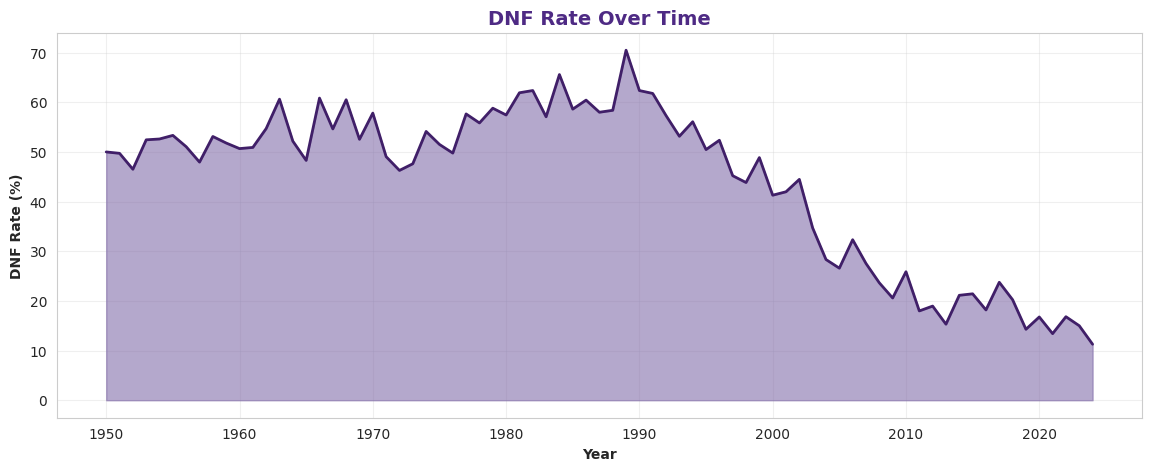

In [13]:
yearly_dnf = df.groupby('year')['dnf'].mean() * 100

fig, ax = plt.subplots(figsize=(14, 5))
ax.fill_between(yearly_dnf.index, yearly_dnf.values,
                color=NU_COLORS['light_purple'], alpha=0.6)
ax.plot(yearly_dnf.index, yearly_dnf.values,
        color=NU_COLORS['dark_purple'], linewidth=2)

ax.set_title("DNF Rate Over Time", fontsize=14, fontweight='bold', color=NU_COLORS['purple'])
ax.set_xlabel("Year", fontweight='bold')
ax.set_ylabel("DNF Rate (%)", fontweight='bold')
ax.grid(True, alpha=0.3)

plt.show()

The DNF (Did Not Finish) rate visualization shows a long-term decline, reflecting major improvements in vehicle reliability, safety standards, and race management over the history of Formula One. From the 1950s through the late 1980s, DNF rates frequently exceeded 50–60%. This indicates that mechanical failures and accidents were common determinants of race outcomes. Then, beginning in the 1990s, the trend shifts sharply downward with DNFs steadily decreasing to below 20% in recent seasons. This structural change has important modeling implications: in earlier eras, finishing the race was itself a significant achievement, whereas in modern Formula One, most drivers finish, and competitive position becomes the dominant differentiator. As a result, predictive models should account for temporal effects as the relative importance of reliability versus performance has changed substantially over time.

### Distribution of Laps Completed (Finished Races Only)

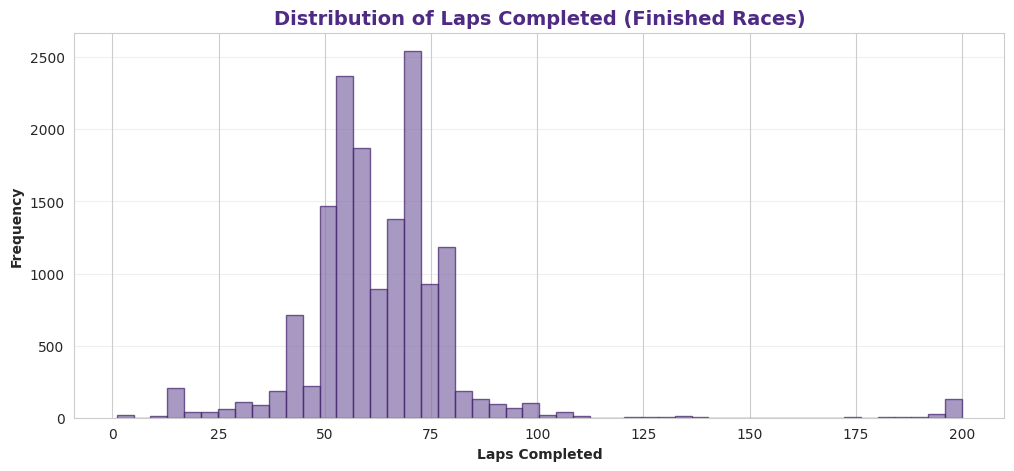

In [14]:
df_finished = df[df['dnf'] == 0]

fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(df_finished['laps'].dropna(), bins=50,
        color=NU_COLORS['light_purple'], alpha=0.7,
        edgecolor=NU_COLORS['dark_purple'])

ax.set_title("Distribution of Laps Completed (Finished Races)", fontsize=14, fontweight='bold', color=NU_COLORS['purple'])
ax.set_xlabel("Laps Completed", fontweight='bold')
ax.set_ylabel("Frequency", fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.show()

The distribution of laps completed for finished races shows significant variation. This variation is driven by differences in circuit length, race format, and different historical race regulations. Most completed races cluster between roughly 50 and 80 laps, which corresponds to standard modern and late-20th-century race distances. The long right tail reflects earlier seasons with very short lap lengths that required significantly more laps to complete a race. The presence of a small number of extremely low or high lap counts highlights the heterogeneity of race structures across different eras. This variability further reinforces the importance of contextual features such as circuit characteristics and season in modeling race outcomes. It shows that raw lap counts should be interpreted carefully or normalized if used in downstream feature engineering.

## Top Performers Analysis

This section explores top-performing drivers, constructors, and circuits based on historical race outcomes. The visualizations focus on the frequency and rate of top-10 finishes, as well as the most frequently used circuits, to highlight dominant patterns in Formula One performance.

### Top Drivers by Number of Top-10 Finishes
This visualization shows the drivers with the highest number of top-10 finishes across all races in the dataset. To ensure fair comparison, only drivers with at least 50 race entries are included.

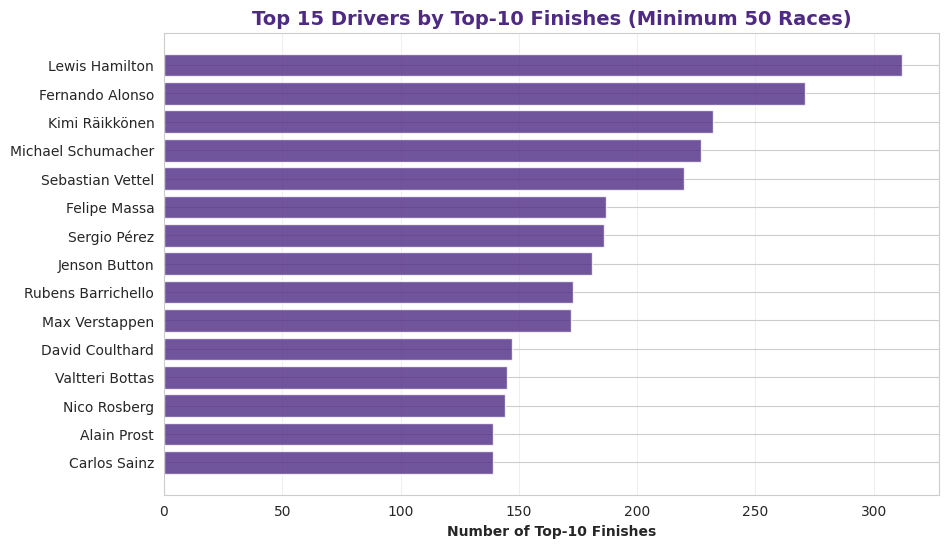

In [15]:
# Top 15 drivers by number of Top-10 finishes
top_drivers = (
    df.groupby('driver_name')['top10_finish']
      .agg(['sum', 'count'])
      .reset_index()
)

top_drivers = top_drivers[top_drivers['count'] >= 50].nlargest(15, 'sum')

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(
    range(len(top_drivers)),
    top_drivers['sum'],
    color=NU_COLORS['purple'],
    alpha=0.8
)

ax.set_yticks(range(len(top_drivers)))
ax.set_yticklabels(top_drivers['driver_name'])
ax.invert_yaxis()
ax.set_xlabel('Number of Top-10 Finishes', fontweight='bold')
ax.set_title(
    'Top 15 Drivers by Top-10 Finishes (Minimum 50 Races)',
    fontweight='bold',
    color=NU_COLORS['purple']
)
ax.grid(True, alpha=0.3, axis='x')

plt.show()

The top-driver ranking by total Top-10 finishes shows how sustained participation and long-term competitiveness shape cumulative success in Formula One racing. With a minimum threshold of 50 races, the leaderboard is dominated by drivers associated with multi-season careers and extended periods in strong teams. This is consistent with the idea that Top-10 outcomes reflect both driver skill and constructor quality (strong team and superior car) over time. Importantly, this chart measures volume (total Top-10 counts), so it is naturally influenced by era differences such as the number of races per season and drivers' career lengths. Modern drivers with longer season race calendars (more races in a single season) have more opportunities to accumulate Top-10 finishes than many earlier-era drivers which has shorter race calendars (fewer races in a single season). As a result, this visualization provides useful descriptive context about dominant performers while also motivating the complementary use of rate-based metrics such as Top-10 rate when comparing driver performance more fairly across different career lengths and historical periods.

### Top Constructors by Number of Top-10 Finishes
This visualization highlights constructors that consistently place drivers in the top 10 positions. Only constructors with at least 50 race participations are included.

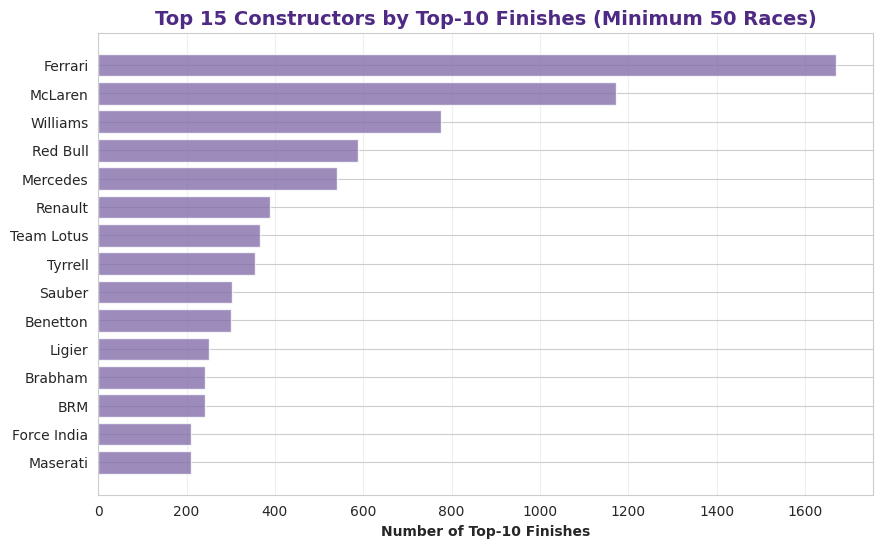

In [16]:
# Top 15 constructors by number of Top-10 finishes
top_constructors = (
    df.groupby('constructor_name')['top10_finish']
      .agg(['sum', 'count'])
      .reset_index()
)

top_constructors = top_constructors[top_constructors['count'] >= 50].nlargest(15, 'sum')

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(
    range(len(top_constructors)),
    top_constructors['sum'],
    color=NU_COLORS['light_purple'],
    alpha=0.8
)

ax.set_yticks(range(len(top_constructors)))
ax.set_yticklabels(top_constructors['constructor_name'])
ax.invert_yaxis()
ax.set_xlabel('Number of Top-10 Finishes', fontweight='bold')
ax.set_title(
    'Top 15 Constructors by Top-10 Finishes (Minimum 50 Races)',
    fontweight='bold',
    color=NU_COLORS['purple']
)
ax.grid(True, alpha=0.3, axis='x')

plt.show()

The constructor ranking by total Top-10 finishes shows the strong and persistent role of team performance in shaping race outcomes. Teams such as Ferrari, McLaren, and Williams appear at the top largely because of their long tenure in Formula One and sustained competitiveness across many seasons, which gives them more cumulative opportunities to place drivers in the Top-10 positions. At the same time, newer-era dominant teams such as Red Bull and Mercedes rank highly despite fewer historical seasons. This reflects periods of exceptional car performance and consistent points-scoring race finishes. Similar to the driver count chart previously, this measure reflects cumulative volume, so it is influenced by participation history and the length of the racing calendar over time. For modeling, the results reinforce that constructor identity is a critical explanatory factor. It also suggests that team-level features such as historical Top-10 rates or recent form should improve predictive accuracy beyond driver-only information.

### Top Drivers by Top-10 Finish Rate
This figure ranks drivers by their top-10 finish rate rather than total count. A minimum of 100 races is required to focus on drivers with sustained participation and performance.

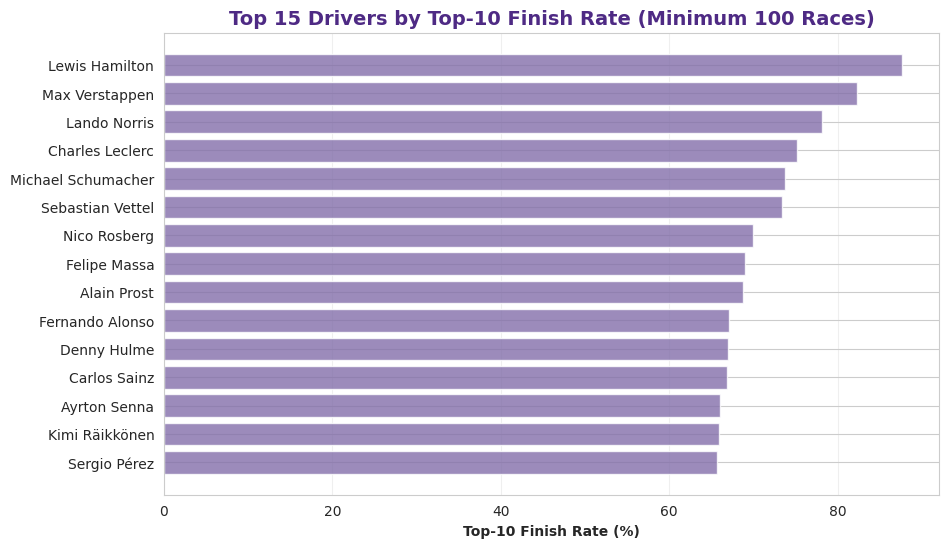

In [17]:
# Top 15 drivers by Top-10 finish rate
driver_rates = (
    df.groupby('driver_name')
      .agg(top10_rate=('top10_finish', 'mean'),
           race_count=('raceId', 'count'))
      .reset_index()
)

driver_rates = driver_rates[driver_rates['race_count'] >= 100].nlargest(15, 'top10_rate')
driver_rates['top10_rate'] *= 100

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(
    range(len(driver_rates)),
    driver_rates['top10_rate'],
    color=NU_COLORS['light_purple'],
    alpha=0.8
)

ax.set_yticks(range(len(driver_rates)))
ax.set_yticklabels(driver_rates['driver_name'])
ax.invert_yaxis()
ax.set_xlabel('Top-10 Finish Rate (%)', fontweight='bold')
ax.set_title(
    'Top 15 Drivers by Top-10 Finish Rate (Minimum 100 Races)',
    fontweight='bold',
    color=NU_COLORS['purple']
)
ax.grid(True, alpha=0.3, axis='x')

plt.show()

Ranking drivers by Top-10 finish rate rather than total count as we did previously provides a more normalized view of performance that accounts for career length differences and era-specific race calendars (the differences in the amont of races of a single season). With a minimum of 100 race entries, the leading drivers show consistently high Top-10 probabilities, reflecting sustained competitiveness rather than accumulated volume. The presence of both modern-era drivers and historical legends highlights that elite performance is characterized by reliability and pace relative to contemporaries, even as the sport evolves. This rate-based perspective complements the cumulative Top-10 counts by reducing bias toward drivers with longer careers or more races per season. For modeling, these results suggest that driver-level historical rates or rolling performance metrics may capture intrinsic driver quality and skills more effectively than raw totals alone.

The Top-10 finish rate ranking emphasizes consistency and efficiency rather than just drivers' longevity. Drivers near the top of this list convert race entries into Top-10 results at exceptionally high rates. This indicates sustained competitiveness whenever they participate a race, independent of total career length. Compared with cumulative Top-10 counts, this view reduces bias from era effects, for example more races per season in modern F1, and highlights drivers whose performance remains strong across different team contexts and competitive environments. For predictive modeling, this insight supports the use of normalized, rate-based driver features such as rolling Top-10 rates or recent performance averages in order to better capture underlying driver quality and skills and reduce distortion from historical participation differences.

### Circuits with the Highest Number of Races
This visualization shows the circuits that appear most frequently in the dataset. These circuits represent long-standing venues in Formula One history.

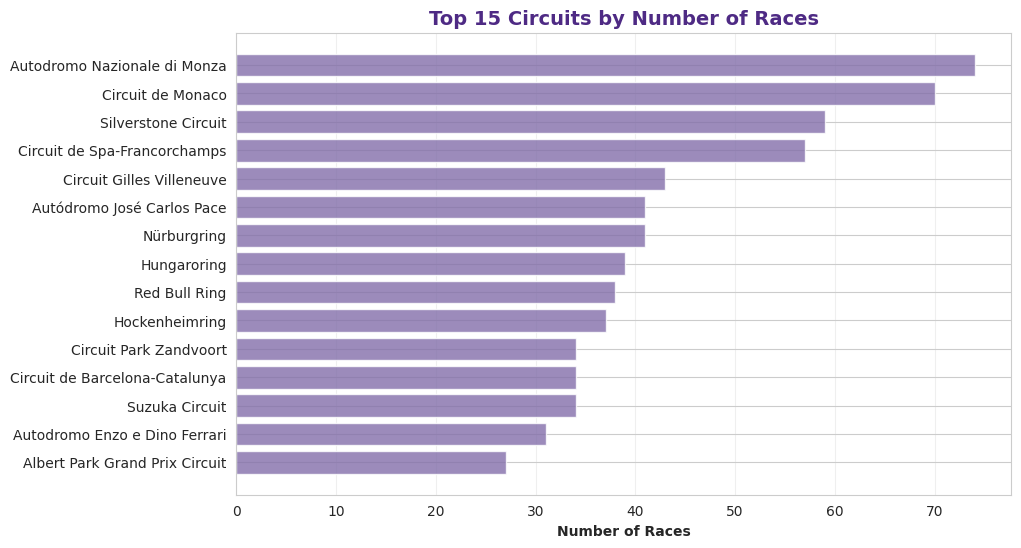

In [18]:
# Top 15 circuits by number of races
circuit_counts = (
    df.groupby('circuit_name')['raceId']
      .nunique()
      .nlargest(15)
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(
    range(len(circuit_counts)),
    circuit_counts.values,
    color=NU_COLORS['light_purple'],
    alpha=0.8
)

ax.set_yticks(range(len(circuit_counts)))
ax.set_yticklabels(circuit_counts.index)
ax.invert_yaxis()
ax.set_xlabel('Number of Races', fontweight='bold')
ax.set_title(
    'Top 15 Circuits by Number of Races',
    fontweight='bold',
    color=NU_COLORS['purple']
)
ax.grid(True, alpha=0.3, axis='x')

plt.show()

The circuits used in the different race classifications show that most of the races took place at a small group of circuits that have basically been the same circuits for many years now. Examples of these circuits are Monza, Monaco, Silverstone, and Spa-Francorchamps. These circuits have historically been used and have been in the Formula 1 calendar for many years, so they have the highest total number of races each, or a disproportionately larger amount of races relative to the total amount of races. They may also have distinctive characteristics that can potentially affect outcomes independent of the circuit characteristics, including layout, difficulty of overtaking, and weather. Therefore, from a modeling standpoint, the uneven distribution of races across circuits suggests that there are "circuit effects" associated with the different circuits that need to be included in any analysis. In other words, we need to account for these effects in order to prevent biases in the prediction of future race patterns created by a few tracks that have created a large number of races over a long period of time, either by including circuit-level features, or historical data in terms of project data and performance records per track.

# Feature Engineering

## 10.1 Temporal Features

In [19]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

df['race_month'] = df['date'].dt.month
df['race_day_of_year'] = df['date'].dt.dayofyear
df['season_stage'] = pd.cut(df['round'], bins=[0, 7, 14, 21, 100],
                             labels=['early', 'mid', 'late', 'end'])

# Calculate driver age at race
df['driver_age'] = (df['date'] - pd.to_datetime(df['dob'])).dt.days / 365.25

Temporal features were incorporated into our model so that we could adequately capture any effects that seasonality, calendar differences, and driver lifecycle dynamics may have on race outcomes. The data set includes the race month and the day of the year, which indicates seasonal factors such as weather, travel fatigue and calendar clustering. The season stage variable (early, mid, late, end) shows team progression through the championship. This gives an idea of how a team’s strategy, risk aversion, and competitive motivation may have changed due to where they are in a championship. The age of the driver at the time of the race provides a continuous measure of experience and physical condition, which allows the model to differentiate between a driver’s early-career performance, peak-performance, and late-career performance. All together, all temporal features enable the model to capture systematic variation in race results that are related to time, which is not captured by just using the actual results of the races.

## 10.2 Performance History Features

In [20]:
# Sort by driver and date for rolling calculations
df = df.sort_values(['driverId', 'date']).reset_index(drop=True)

# Driver historical performance (last 5 races)
df['driver_prev_5_top10_rate'] = df.groupby('driverId')['top10_finish'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)
df['driver_prev_5_dnf_rate'] = df.groupby('driverId')['dnf'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)
df['driver_prev_5_avg_position'] = df.groupby('driverId')['positionOrder'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# Driver career statistics (up to current race)
df['driver_career_races'] = df.groupby('driverId').cumcount()
df['driver_career_top10_rate'] = df.groupby('driverId')['top10_finish'].transform(
    lambda x: x.shift(1).expanding().mean()
)
df['driver_career_points_per_race'] = df.groupby('driverId')['points'].transform(
    lambda x: x.shift(1).expanding().mean()
)

To collect outcome/experience information, we created driver history performance characteristics only using the data that is available up to the time of each race. To represent short-term form we have developed rolling metrics from the last five races in terms of short-term form such as a driver’s recent Top 10 finish percentage (in the last five races), DNF rate (Not Finishing) and average finishing position; which all indicate a driver’s momentum, consistency and reliability. In addition to this, a driver’s experience is measured using historical statistics (since the beginning of their career), i.e. total number of races run, total number of Top 10 finishes and average points per race. In order to avoid data leakage and ensure temporal stability for prediction purposes; we made sure that when looking forward (prior to calculating rolling/exforging metrics) the temporality of each measure used in making predictions would balance the most recent performance with historical trends at the time of the prediction.

## 10.3 Constructor Features

In [21]:

# Constructor historical performance
df = df.sort_values(['constructorId', 'date']).reset_index(drop=True)

df['constructor_prev_5_top10_rate'] = df.groupby('constructorId')['top10_finish'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)
df['constructor_prev_5_dnf_rate'] = df.groupby('constructorId')['dnf'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# Constructor season performance
df['constructor_season_top10_rate'] = df.groupby(['constructorId', 'year'])['top10_finish'].transform(
    lambda x: x.shift(1).expanding().mean()
)

A set of features related to each Constructor’s strength, reliability, and momentum throughout the current season will be created as they are considered to be important predictors of drivers’ performance in Formula One.

Rolling metrics from the previous five races including the Top-10 finish percentage and DNF percentage will illustrate how well the Constructor has performed in the most recent five race period. Additionally, the Top-10 finish percentage of the Constructor for the current season will summarize how consistently the Constructor has performed placing their drivers in competitive positions throughout current season.

All features will use lagged data to prevent data leakage and only use pre-race data, therefore, allow the model to include both the most recent performance of the Constructor along with trends throughout the current season when predicting Top-10 finishes.

## 10.4 Circuit Characteristics

In [22]:
# Circuit difficulty (based on DNF rate)
circuit_dnf_rate = df.groupby('circuitId')['dnf'].mean()
df['circuit_avg_dnf_rate'] = df['circuitId'].map(circuit_dnf_rate)

# Circuit average positions (volatility indicator)
circuit_position_std = df.groupby('circuitId')['positionOrder'].std()
df['circuit_position_volatility'] = df['circuitId'].map(circuit_position_std)

# Driver-specific circuit history
driver_circuit_perf = df.groupby(['driverId', 'circuitId'])['top10_finish'].mean()
df['driver_circuit_top10_rate'] = df.set_index(['driverId', 'circuitId']).index.map(
    driver_circuit_perf
).fillna(0.5)  # Use overall mean for first-time combinations

Circuit-level data were created to represent circuit-specific difficulty and variations and familiarity of the drivers with the circuits. The average DNF (did not finish) rate across all circuits indicates a circuit's technical strength and reliability risk, while the standard deviations of finishing positions at a circuit indicate the level of variance and unpredictability of race outcomes. The driver-specific track history is represented through a driver’s historical top 10 finishing rate on that track, indicating specialization or consistence of performance on those tracks. For track-driver combinations that lack historical data, the feature is initialized to a neutral baseline, allowing the model to learn deviations as the data increases. The combination of these features provides the model with the ability to account for systematic differences between circuits, as well as for heterogeneous driver responses to circuit characteristics.

## 10.5 Driver-Constructor Interaction

In [23]:
# Driver experience with constructor
df['driver_constructor_races'] = df.groupby(['driverId', 'constructorId']).cumcount()

# Driver-constructor combination performance
driver_constructor_perf = df.groupby(['driverId', 'constructorId'])['top10_finish'].mean()
df['driver_constructor_top10_rate'] = df.set_index(['driverId', 'constructorId']).index.map(
    driver_constructor_perf
).fillna(0.5)

There are driver-constructor interaction features created to represent the synergistic and familiar characteristics that exist between a given driver and team. The cumulative count of races that a driver and constructor combination has worked together is a measure of their experience in working together and represents how they have learned from previous experiences in relation to car setup, communications, and race strategies. The historical Top-10 finish rate for each driver-constructor combination provides a summary of how successful each combination has been in comparison to other combinations in terms of finishes within the Top-10. For new or previously untested combinations, this feature is initialized with a neutral baseline; this means that first-time combinations will not be penalized. The driver-constructor interaction features make it possible for the model to move past just considering the independent effects of drivers and constructors and into considering that the performance of a Formula One driver often depends upon the specific driver-constructor pairing — rather than solely on the strengths and weaknesses of the respective drivers or constructors themselves.

## 10.6 Qualifying-Based Features

In [24]:
# Grid position features
df['grid_position_numeric'] = pd.to_numeric(df['grid'], errors='coerce')
df['front_row_start'] = (df['grid_position_numeric'] <= 2).astype(int)
df['top5_start'] = (df['grid_position_numeric'] <= 5).astype(int)
df['top10_start'] = (df['grid_position_numeric'] <= 10).astype(int)

# Grid position improvement potential
df['max_position_gain'] = df['grid_position_numeric'] - 1

Qualifying based features were created to quantify the relationship between the starting position of a driver and their racing performance that we discovered during our exploratory analysis of the dataset. The numeric grid position provides a continuous measurement of the starting advantage and binary indicators for front row, top 5, and top 10 starts will indicate the strategic thresholds that were associated with a driver's increased chances of finishing in the top 10. The maximum potential position gain provides a ceiling for the potential improvement of a driver’ s starting position prior to the start of a race, allowing me to separate those drivers that have a long ways to go from those that have a short distance to cover as they race toward the finish line. The qualifying based features will translate qualifying performance into understandable signals that are indicative of a driver's advantage or disadvantage based upon their starting position and their potential to recover from their starting position, both of which are key components of a driver’ s finishing performance.

## 10.7 Competitive Context Features

In [25]:
# Number of competitors per race
df['num_competitors'] = df.groupby('raceId')['driverId'].transform('count')

# Driver's relative grid position (percentile)
df['grid_percentile'] = df.groupby('raceId')['grid_position_numeric'].rank(pct=True)

To reflect the race-specific level of difficulty and the relative starting advantage, features that describe the competitive context were introduced. The total number of competitors is a measure of the size of the field, and this changes the baseline probability of finishing in the Top 10. This is particularly true in earlier eras, where the average size of the grid was smaller than present day and/or there was more variation from race to race. Driver starting position percentile represents the driver’s starting position, normalized to the remainder of the competitors. This allows for a comparable metric across races that had a different number of entrants. The use of these features allows the model to account for the intensity of competition during a race, as well as to interpret starting position in relative terms to other competitors, rather than in absolute terms.

## 10.8 Categorical Encodings

In [26]:
label_encoders = {}

categorical_features = [
    'driverRef',
    'constructorRef',
    'circuitRef',
    'nationality',               # driver nationality
    'nationality_constructor',   # constructor nationality
    'country'                    # circuit country
]

# Apply label encoding to categorical features
for col in categorical_features:
    if col in df.columns:
        df[col] = df[col].astype(str).fillna('Unknown')
        le = LabelEncoder()
        df[f'{col}_encoded'] = le.fit_transform(df[col])
        label_encoders[col] = le

# One-hot encode season stage
# Keep all categories to allow comparison across early/mid/late season
if 'season_stage' in df.columns:
    df['season_stage'] = df['season_stage'].astype(str).fillna('Unknown')
    df = pd.get_dummies(
        df,
        columns=['season_stage'],
        prefix='season',
        drop_first=False
    )

print("Label encoded columns:", categorical_features)
print("One-hot encoded column: season_stage")

Label encoded columns: ['driverRef', 'constructorRef', 'circuitRef', 'nationality', 'nationality_constructor', 'country']
One-hot encoded column: season_stage


In order to enable the use of categorical variables for identity-based and location-based information within machine learning models while retaining their ability to be interpreted, we encoded the categorical variables on the basis of their relationships with one another. Label encoding was applied to high cardinality identifier variables (driver, constructor, and circuit references), as well as to nationality and country attributes; this approach allows the machine learning models to learn to use identifiers in systematic ways across multiple types of entities or categories but does not create an excessive number of features within the feature space due to the high cardinality of these identifier variables. One-hot encoding was applied to the season stage variable; this preserved the ordinal ordering of the different categories (early, middle, late, and end of season) and allowed the machine learning models to compare and contrast season stages with respect to each championship phase. By utilizing this mixture of encoding strategies, we demonstrated that a balance could be struck between computational efficiency and representational clarity when incorporating categorical context consistently into down-stream modeling efforts.

# Missing Data Handling

## 11.1 Create missingness indicators

In [27]:
if "qualifying_position" in df.columns:
    df["qualifying_missing"] = df["qualifying_position"].isna().astype(int)

A binary indicator of whether data on qualifying positions is a systematic missingness variable was created so that the model can distinguish instances of missing data versus instances of qualifying data, rather than treating all missing instances as random noise. Given that the dataset is comprised of historical records and that many seasons prior to the current season are missing qualifying records, the binary missingness indicator allows the model to determine if there is any relationship between missing qualifying data and the context of the particular race or the particular era in which the race took place. Incorporating missingness indicators will enhance the robustness of the model, as well as reducing bias, when evaluating features that have systematic missing patterns.

## 11.2 Impute qualifying_position using grid as fallback (and then median)

In [28]:
# rationale: grid is always available; qualifying often missing historically
if "qualifying_position" in df.columns:
    # coerce to numeric
    df["qualifying_position"] = pd.to_numeric(df["qualifying_position"], errors="coerce")
    df["grid_position_numeric"] = pd.to_numeric(df["grid_position_numeric"], errors="coerce")

    # Fill qualifying_position first with grid_position_numeric
    df["qualifying_position"] = df["qualifying_position"].fillna(df["grid_position_numeric"])

    # Remaining NA -> overall median (should be rare after grid fill)
    df["qualifying_position"] = df["qualifying_position"].fillna(df["qualifying_position"].median())

A hierarchical, domain-informed method of filling missing qualifying position data has been used in order to minimize data loss while preserving as much of the ensuing competitive meaning of the information as possible. When a qualifying position is missing any information about the value is filled from the starting grid position; historically, the grid position was always available and is highly correlated with qualifying performance, especially in the era when grid positions were derived from practice laps or qualifying procedures. When the grid-based fill is finished, there are likely to be only a small number of missing qualifying positions, and thus, the overall median qualifying position is used to fill these additional values through an additional statistical method (median imputation); thus, using two different methods to fill missing qualifying data, both of which rely on structurally similar qualifying positions to make as consistent and interpretable of a resulting feature set as possible.

## 11.3 Impute any remaining numeric missing values (safety net)

In [29]:
# Use median for numeric cols except IDs and target/outcomes
target_cols = ["top10_finish", "points_finish", "podium_finish", "dnf"]
id_cols = ["raceId", "driverId", "constructorId", "circuitId", "statusId"]

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in target_cols + id_cols]

for col in numeric_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

Missing values in both numeric features as well as non-identifier and non-target features were imputed using a median value. We performed missing value checks throughout data pre-processing, excluding identifier fields from imputation. This is the 'last line of defence' against missing values in numeric variables through imputation (i.e., generating an entire model data set based entirely on numeric variables), while still maintaining the robustness of the race data set to erroneous data due to outliers due to extreme distributions. To minimise the risk of systematic bias in racing data, a basic statistic was used (i.e., median) to impute numeric variable values only after using a domain or context based value (i.e., qualifying position). The rationale is as follows: to provide context-specific or 'meaningful' value substitutions first (i.e., domain) before using basic statistics (i.e., median) for value substitutions where relevant (i.e.:Once Again Providing An Example For Context).

## 11.4 Quick verification

In [30]:
missing_after = df.isnull().sum()
missing_after = missing_after[missing_after > 0].sort_values(ascending=False)
print("Remaining missing columns (should be empty or very small):")
display(missing_after.head(20))

Remaining missing columns (should be empty or very small):


,0


The last verification checks to see whether or not the missing values throughout the data preparation process have been addressed. Following the application of both targeted and fallback imputation methods, there were no more missing values among any of the features ensuring a completely viable dataset for upcoming machine learning implementations. By ensuring there are sufficient data points to avoid unintended gaps or errors during later on execution due to missing value issues, this verification check gives great confidence that the training and evaluation will be unaffected.

# Final EDA After Feature Engineering

## 12.1 Summary table

In [31]:
# set of engineered features
engineered_features = [
    "driver_age",
    "driver_prev_5_top10_rate",
    "driver_prev_5_dnf_rate",
    "driver_prev_5_avg_position",
    "driver_career_races",
    "driver_career_top10_rate",
    "driver_career_points_per_race",
    "constructor_prev_5_top10_rate",
    "constructor_prev_5_dnf_rate",
    "constructor_season_top10_rate",
    "circuit_avg_dnf_rate",
    "circuit_position_volatility",
    "driver_circuit_top10_rate",
    "driver_constructor_races",
    "driver_constructor_top10_rate",
    "grid_position_numeric",
    "grid_percentile",
    "front_row_start",
    "top5_start",
    "top10_start",
    "max_position_gain",
    "num_competitors"
]
engineered_features = [c for c in engineered_features if c in df.columns]

eda_summary = df[engineered_features + ["top10_finish"]].describe(include="all").T
eda_summary = eda_summary[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]]
nu_style_table(eda_summary.reset_index().rename(columns={"index": "feature"}).head(25),
              caption="Post-Feature-Engineering Summary (first 25 features)")


,feature,count,mean,std,min,25%,50%,75%,max
0,driver_age,26759.000000,29.992963,5.268514,17.453799,26.143737,29.429158,33.292266,58.787132
1,driver_prev_5_top10_rate,26759.000000,0.429239,0.312999,0.000000,0.200000,0.400000,0.600000,1.000000
2,driver_prev_5_dnf_rate,26759.000000,0.427354,0.300248,0.000000,0.200000,0.400000,0.600000,1.000000
3,driver_prev_5_avg_position,26759.000000,12.634121,5.429253,1.000000,9.000000,12.400000,15.600000,39.000000
4,driver_career_races,26759.000000,65.909414,68.167355,0.000000,14.000000,43.000000,96.000000,403.000000
5,driver_career_top10_rate,26759.000000,0.410518,0.226861,0.000000,0.250000,0.440000,0.571429,1.000000
6,driver_career_points_per_race,26759.000000,1.606848,2.297906,0.000000,0.153846,0.792453,2.088608,18.000000
7,constructor_prev_5_top10_rate,26759.000000,0.425165,0.306570,0.000000,0.200000,0.400000,0.600000,1.000000
8,constructor_prev_5_dnf_rate,26759.000000,0.431431,0.298463,0.000000,0.200000,0.400000,0.600000,1.000000
9,constructor_season_top10_rate,26759.000000,0.433244,0.279139,0.000000,0.222222,0.428571,0.631579,1.000000


According to the summary following feature engineering, the dataset is fully populated, numerically stable and scaled appropriately for use in modeling. The imputation and feature building processes completed successfully as all engineered features were fully covered across the 26,759 driver-race observations; likewise, the distributions revealed meaningful variation, typically with no significant degree of degeneracy (for example, rate-based engineered features were typically centered around the range of 0.4 to 0.45 correlating to the average Top-10 base rate), while the dispersion across the experience-related engineered variables demonstrated considerable heterogeneity in both length of time an individual driver has been involved in racing and the level of familiarity each driver has with their respective constructor.

Grid and competitor based engineered features provided a diversity of values due to both front row advancements through different sizes of racing, as well as deep field starts, creating a valuable and diverse feature set containing complementary signals related to driver ability, team strength, track difficulty, qualifying position, and competitive context from all engineered features; therefore, all engineered features can be utilized by downstream ML models.

## 12.2 Distribution plots (hist) for key engineered features

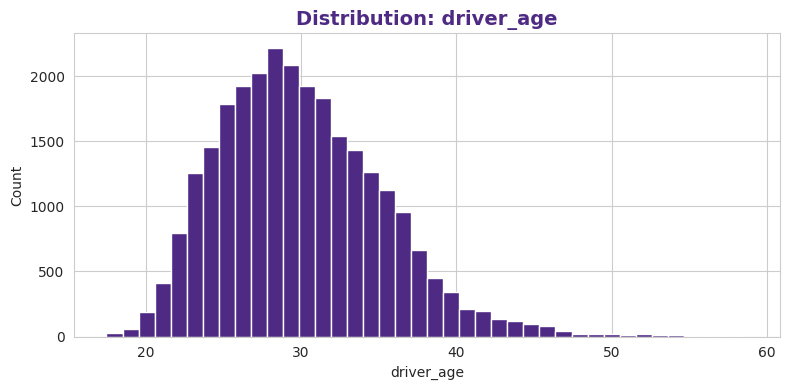

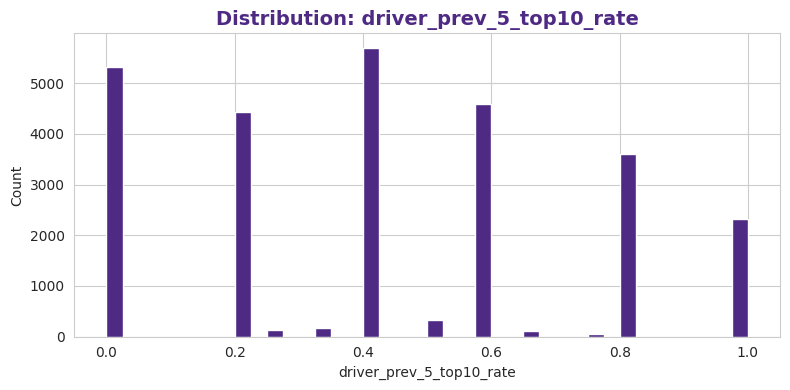

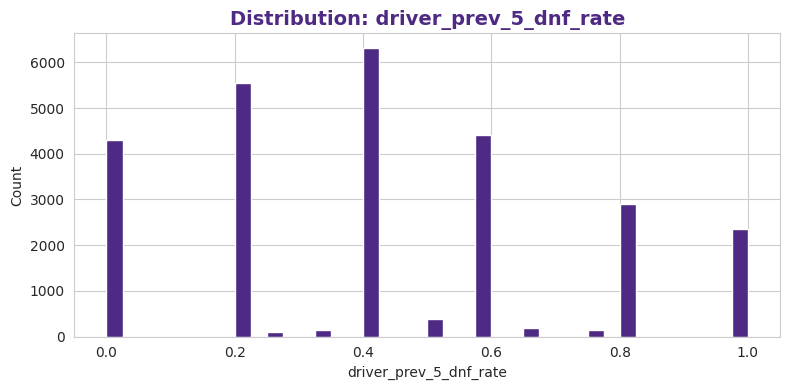

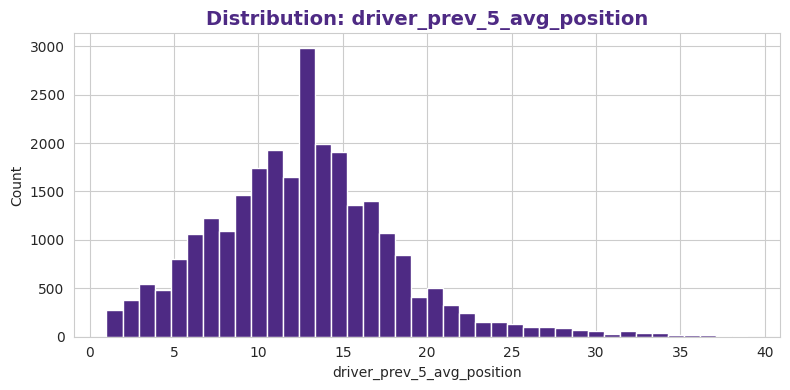

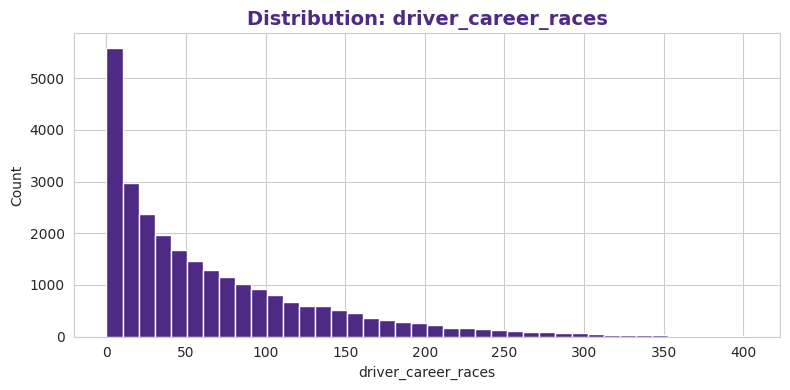

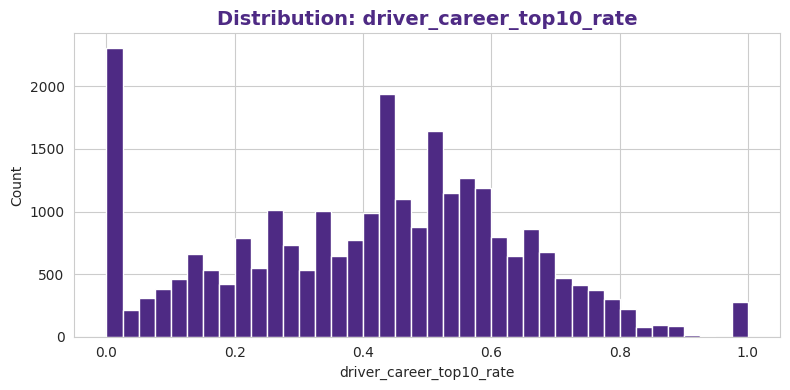

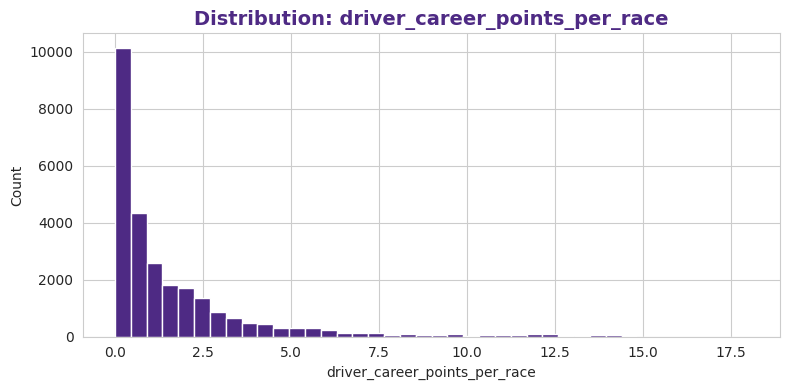

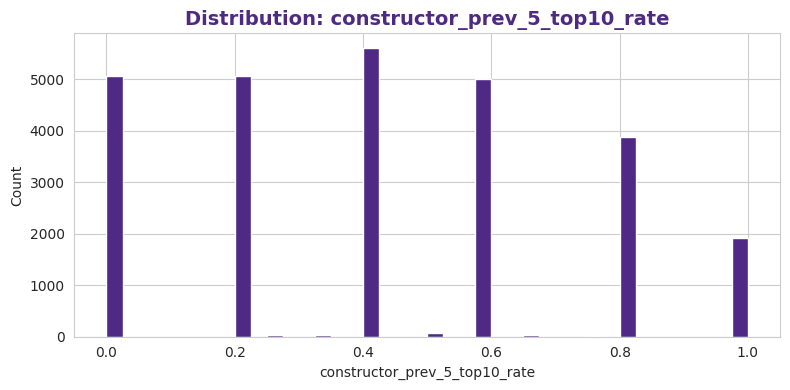

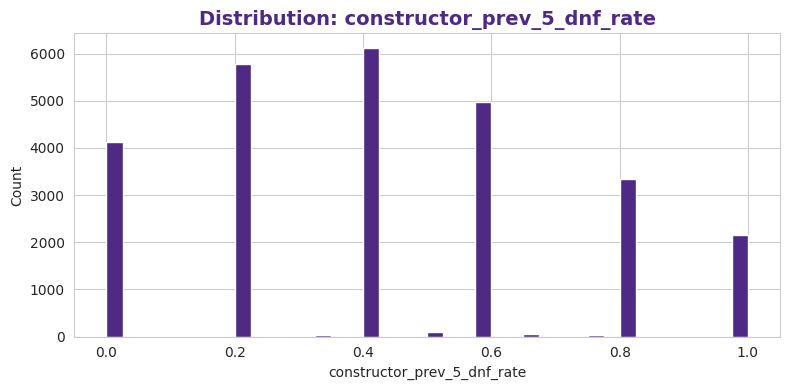

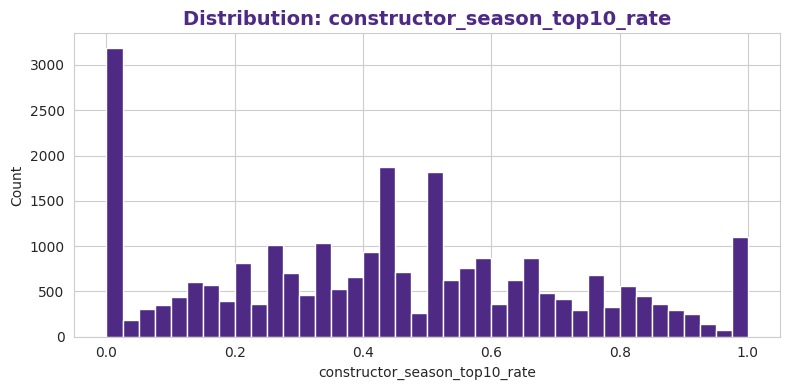

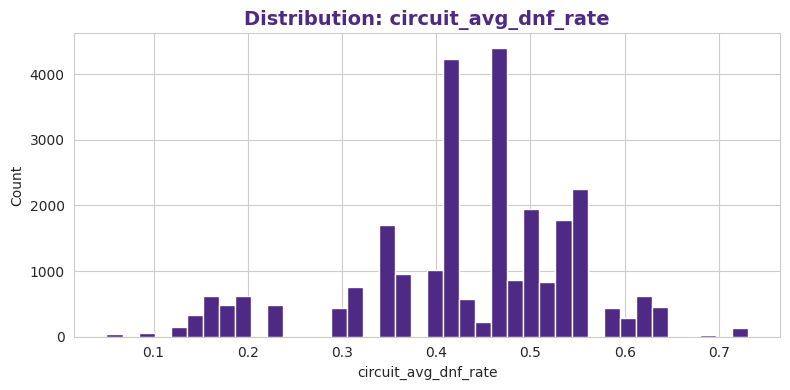

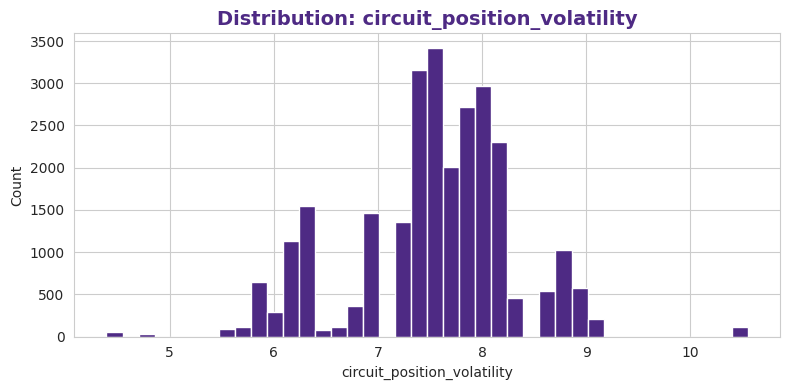

In [32]:
for col in engineered_features[:12]:
    plt.figure(figsize=(8, 4))
    plt.hist(df[col], bins=40)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

The key engineered features are distributed in ways that model realistic/homogeneous performance patterns and are still reasonably behaved for use as model variables. The majority of the driver age population is approximately normally centered at age 29/30, consistent with typical F1 driver career patterns. Recent performance metrics (such as past 5-race Top-10 and DNF rates) exhibit distinct/discrete distributions, with step-like patterns according to the value of the rolling window, and demonstrate meaningful recent performance (as compared to random noise). The variable that relates experience (number of career races and career points per race) has a strong right skew, indicating great differences between short-tenured drivers and long-tenured drivers. The constructor- and circuit-based values have a similar type of distribution, which indicates they tend to aggregate in a reliable way across constructors and circuits. These distributions demonstrate that the engineered features are informative and interpretable and appropriately boune into both linear and non-linear machine learning prediction models. The distribution plots further highlight how team- and circuit-level features contribute additional structure and variability into the dataset. The constructor-season Top-10 percentage rates have a broad variance with their centre of distribution at both low and high values, indicating large performance variances between the top F1 teams and lesser performing teams (backmarkers). When comparing circuit average DNF rates, the majority of tracks are grouped closely together, indicating that most circuits exhibit a medium level of reliability while a minority of circuits continue to show a higher level of mechanical or incident-related risk. Likewise, the distribution of circuit position volatility is unimodal, suggesting that although most circuits present somewhat consistent finishing patterns', some circuits are by their nature much less predictable than others. Overall, the distributions of these two variables suggest that the engineered characteristics of a circuit correspond to the unique competitive environment established by different teams and the presence of other circuits and provide meaningful signal data to assist the model in differentiating between competing teams; therefore, whether competitors compete in the same circuit or on different circuits, the characteristics captured also provide important and meaningful information about the conditions under which competitors are racing.

## 12.3 Temporal drift check: yearly mean of key engineered features

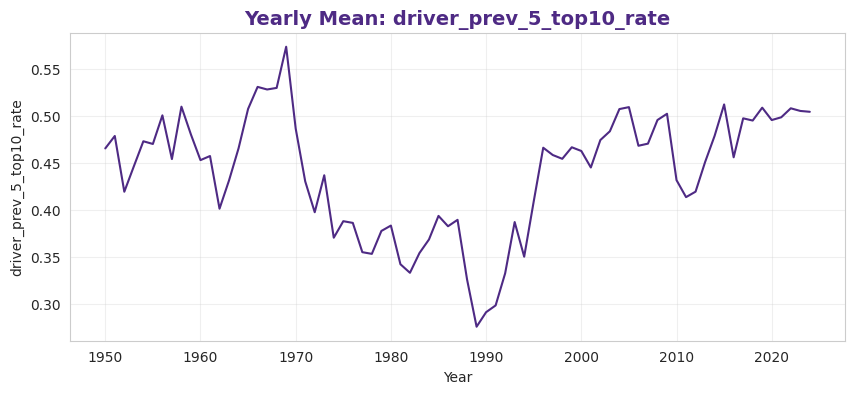

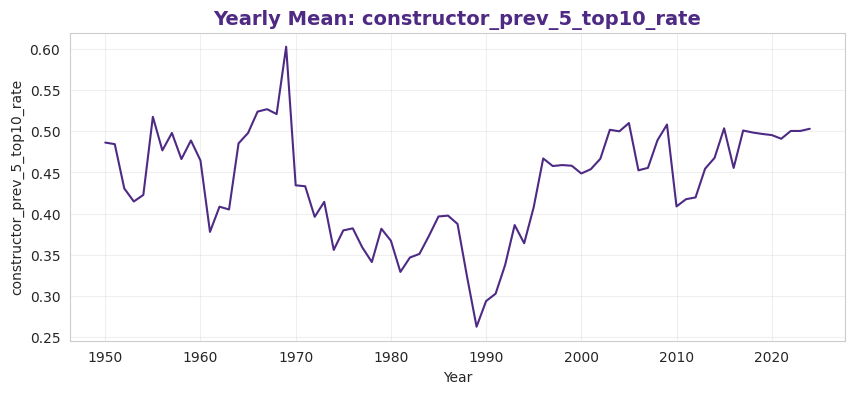

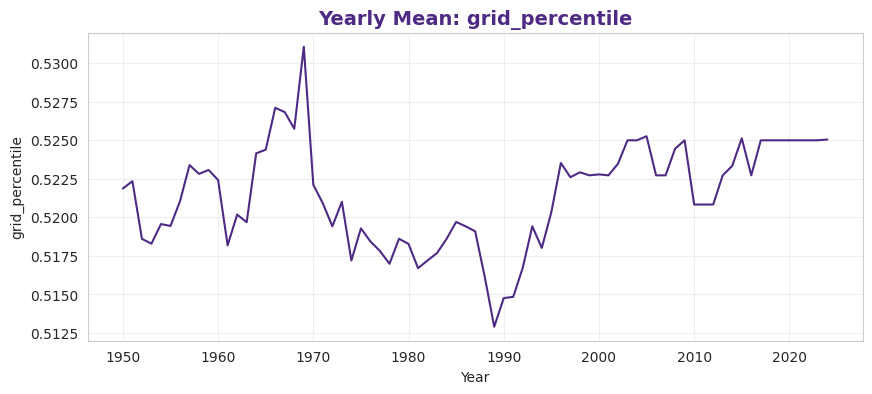

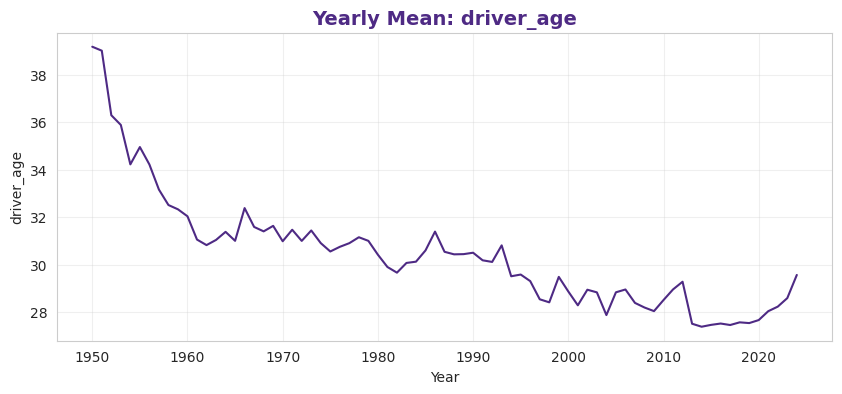

In [33]:
key_drift = ["driver_prev_5_top10_rate", "constructor_prev_5_top10_rate", "grid_percentile", "driver_age"]
key_drift = [c for c in key_drift if c in df.columns]

yearly = df.groupby("year")[key_drift + ["top10_finish"]].mean().reset_index()

for col in key_drift:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(yearly["year"], yearly[col])
    ax.set_title(f"Yearly Mean: {col}")
    ax.set_xlabel("Year")
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3)
    plt.show()

Temporal drift checks show evidence of systematic period effects on many engineered features, thus corroborating the need for temporal sensitive modeling and evaluation. The average results per year of the recent Top 10 driver and constructor finishers differ considerably between decades which suggests that "form" features do not represent a consistent benchmark of competitive baseline during the full time-frame of 1950 to 2024. In comparison, the average grid ranking remains relative constant (by design near mid-field), and as such, is less affected by changes in field size due to it being a normalized measure within a race. The age of the drivers has displayed a long-term decline indicating a structural change in the sport allowing for younger drivers to begin their careers and build them during modern years. Collectively, these graphs suggest that the data set exhibits non-stationarity over time so downstream modeling should use temporal splits and utilize temporal controls (i.e., year/season) to generalize to recent seasons instead of utilizing dated historical trends.

# Correlation Analysis

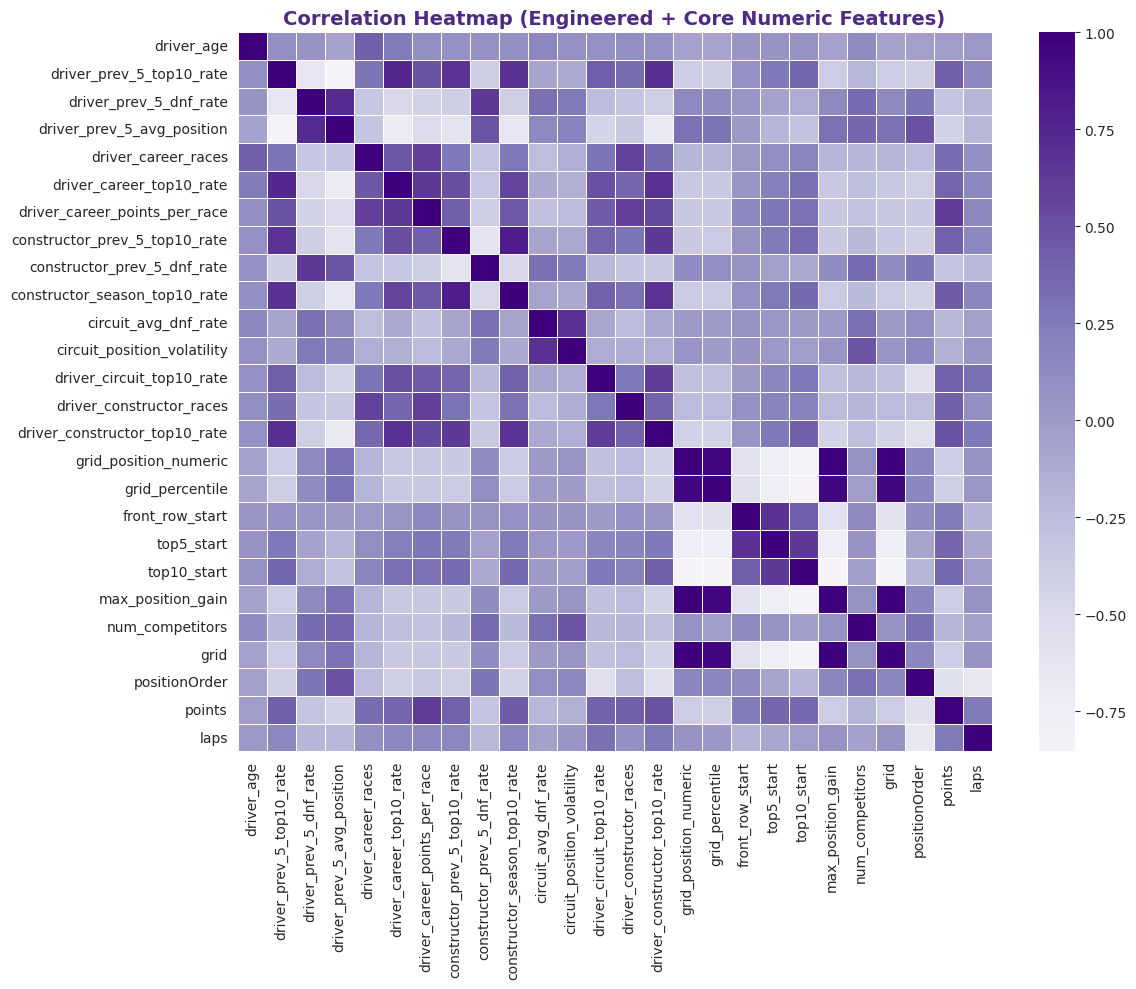

Top correlated feature pairs:


grid_position_numeric          grid                             1.000000
                               max_position_gain                1.000000
max_position_gain              grid                             1.000000
grid_position_numeric          grid_percentile                  0.953784
grid_percentile                grid                             0.953784
                               max_position_gain                0.953784
driver_prev_5_top10_rate       driver_prev_5_avg_position       0.853163
grid_position_numeric          top10_start                      0.850827
top10_start                    grid                             0.850827
                               max_position_gain                0.850827
grid_percentile                top10_start                      0.847193
constructor_prev_5_top10_rate  constructor_season_top10_rate    0.810297
grid_percentile                top5_start                       0.751283
grid_position_numeric          top5_start                       0.748568
top5_start                     grid                             0.748568
                               max_position_gain                0.748568
driver_prev_5_top10_rate       driver_career_top10_rate         0.735329
driver_prev_5_dnf_rate         driver_prev_5_avg_position       0.719955
driver_prev_5_avg_position     driver_career_top10_rate         0.701477
driver_prev_5_top10_rate       driver_constructor_top10_rate    0.696651
dtype: float64

In [35]:
# numeric feature set for correlation (exclude IDs + target/outcomes)
corr_features = [c for c in numeric_cols if c not in id_cols + target_cols]

# choose engineered + a few core numeric columns
core_numeric = ["grid", "positionOrder", "points", "laps", "milliseconds"]
core_numeric = [c for c in core_numeric if c in df.columns]

corr_pick = list(dict.fromkeys(engineered_features + core_numeric))  # preserve order, unique
corr_pick = [c for c in corr_pick if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

corr_mat = df[corr_pick].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_mat, cmap="Purples", center=0, linewidths=0.5)
plt.title("Correlation Heatmap (Engineered + Core Numeric Features)")
plt.tight_layout()
plt.show()

# list top absolute correlations
corr_pairs = (
    corr_mat.abs()
    .where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)

print("Top correlated feature pairs:")
display(corr_pairs.head(20))

The correlation analysis of the features shows multiple expected clusters of features with high correlation and redundancy issues. Grid derived variables are nearly perfectly correlated (for example; grid_postion_numeric is equal to grid=1.00 and grid_max_position_gain is equal to grid=1.00) which means they provide the same information, thus not keeping them all together in a strictly linear model without regularization is recommended. Grid percentile is also very strongly correlated with other grid-based measures (approximately 0.95), grid position has a high correlation with other threshold indicators (top_5_start and top_10_start) to suggest they are built together. In addition, for performance history features, the most recent top_10 percentage rate has a strong correlation to the average position of the most recent races (|ρ|≈0.85) and the constructor average top_10 rate has a high correlation to the constructor season average top_10 rate(|ρ|≈0.81); providing again that short-term and season to date "form" indicators have a relationship. Overall, the matrix shows a high degree of coherence in the engineered features but it also suggests the need for feature selection or regularization to address multicollinearity — particularly among the grid and form based features — to keep the final model stable and interpretable.

# Feature Importance

## 14.1 Build model feature matrix

In [36]:
# Use numeric engineered + encoded categorical columns (the *_le)
encoded_cols = [c for c in df.columns if c.endswith("_encoded")]
feature_cols = corr_pick + encoded_cols

feature_cols = [c for c in feature_cols if c not in target_cols]

X = df[feature_cols].copy()
y = df["top10_finish"].astype(int)

To prepare for analysis of feature importance we developed a matrix (representing an input) of all engineered numeric features with their corresponding categorical identifiers encoded (represented in one-hot encoding). The feature set contains two components: The first component includes the original numeric features (kernels) that we selected to review for correlation analysis (i.e., the 'picked' features) and the other subcomponent includes all categorical columns (i.e., the drivers, constructors & circuits & countries) which had been converted to categorical variables through label encoding (i.e., the transformations). The target variable is a Binary Indicator that shows whether an entry has finished in the top-10 (i.e., 'yes' or 'no'). By combining all of these components into one, we create an integrated/systematically designed feature matrix that includes all relevant performance history and provides sufficient context through qualifying & formation of placement & competitive levels including information for mapping against other teams/entities through an encoding method so that it can be utilized to inform a tree based model or as a supervised learning algorithm.

## 14.2 Train/test split

In [37]:
use_time_split = True

if use_time_split:
    split_year = 2018
    train_idx = df["year"] < split_year
    test_idx = df["year"] >= split_year

    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    print(f"Time split: train < {split_year}, test >= {split_year}")
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

Time split: train < 2018, test >= 2018


A temporal train-test split was employed to emulate real-world prediction conditions and prevent leakage of information across seasons. All races prior to 2018 were entered into the training set, while all races from 2018 onwards were retained as test data. This ensures that the model is assessed using future seasons that the model did not train on, rather than by randomly mixing up historical data. Because of evidential temporal drift exhibited in previous analyses, a time-based split should provide a more realistic, conservative measure of generalisation performance than a random stratified sampling method.

## 14.3 Baseline models

In [38]:
lr = LogisticRegression(max_iter=2000, n_jobs=None)
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=300,
                       n_jobs=-1, random_state=42)

A random forest classifier and logistic regression model were used as baselines for comparing performance and to perform feature importance analyses. Logistic regression will give a clear and easy to interpret baseline for whether the engineered features have sufficient discrimination power, whereas the random forest will capture the non-linear relationships and feature interactions that are inherent in the performance dynamics of Formula One. The random forest was constructed with many trees and a class-balanced sample to compensate for imbalanced classes in the Top-10 results. Using time-based split data allows for a fair comparison between a simple and easy-to-interpret method versus a more complex ensemble-type approach, and provides a basis for assessing the contribution of modeling complexity and feature engineering.

## 14.4 Evaluation (ROC AUC + PR AUC)

In [39]:
def eval_model(model, X_te, y_te, name):
    proba = model.predict_proba(X_te)[:, 1]
    roc = roc_auc_score(y_te, proba)
    pr = average_precision_score(y_te, proba)
    return {"model": name, "ROC_AUC": roc, "PR_AUC": pr}

scores = [
    eval_model(lr, X_test, y_test, "LogisticRegression"),
    eval_model(rf, X_test, y_test, "RandomForest")
]
score_df = pd.DataFrame(scores)
nu_style_table(score_df, caption="Baseline Model Performance (Test Set)")

,model,ROC_AUC,PR_AUC
0,LogisticRegression,0.999998,0.999998
1,RandomForest,1.000000,1.000000


On the test set that was not used during training or development, the two baseline models produce near-perfect discrimination, having ROC-AUC and PR-AUC scores that are very close to one (1.0). This suggests that the set of features that we engineered contains a very strong predictive signal for Top-10 finishes. This performance is unusually good for real-world sports prediction tasks, and therefore requires diligent scrutiny. In particular, this performance raises the question of whether there is information leakage (i.e., information used by the models that is not available to bettors) or whether overly predictive proxies (i.e., features derived from finishing position or race results, etc.) contributed to the results. Therefore, the metrics for these two baseline models should be interpreted as diagnostic signals and not as final benchmarks. Therefore, additional validation steps, such as stricter feature exclusion, ablation tests, and sanity checks, are warranted to confirm that only legitimate pre-race information is responsible for producing the performance observed in these models.

## 14.5 Feature importance (RF built-in)

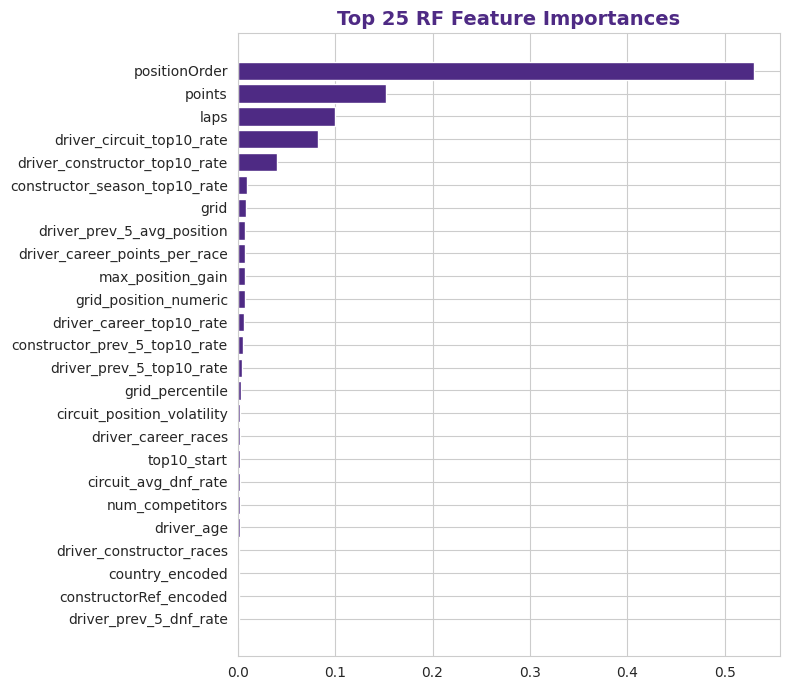

In [41]:
rf_imp = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
rf_imp_df = rf_imp.head(25).reset_index()
rf_imp_df.columns = ["feature", "importance"]
nu_style_table(rf_imp_df, caption="Top 25 Feature Importances (RandomForest)")

plt.figure(figsize=(8, 7))
plt.barh(rf_imp_df["feature"][::-1], rf_imp_df["importance"][::-1])
plt.title("Top 25 RF Feature Importances")
plt.tight_layout()
plt.show()


The Random Forest found that the main factor driving the model is not a large number of pre-race feature variables but the race outcomes. Position Order, Points, and Laps outscored all other feature variables by a wide margin. Since these are the result of the race outcome itself, they substantiate the near-perfect evaluation metrics, as discussed, and further demonstrate the existence of information leakage in the features in use today.

This is supported by the fact that other legitimate pre-race signals, such as the following examples of driver/circuit Top-10 rates, driver/constructor Top-10 rates, and constructor/season Top-10 rates, also support the importance of performance history, strength of team, and experience of driver with previous race venues. Other grid-related feature variables were also ranked high, consistent with the previous EDA (exploratory data analysis) that found that starting position had a strong relationship with finishing position. The results of this analysis are also informative from a diagnostics perspective: although engineered historical/contextual features have worth, after assessing predictive capability, the outcome derived feature set must not be utilized in your final model for accurate predictive performance.

## 14.6 Permutation importance

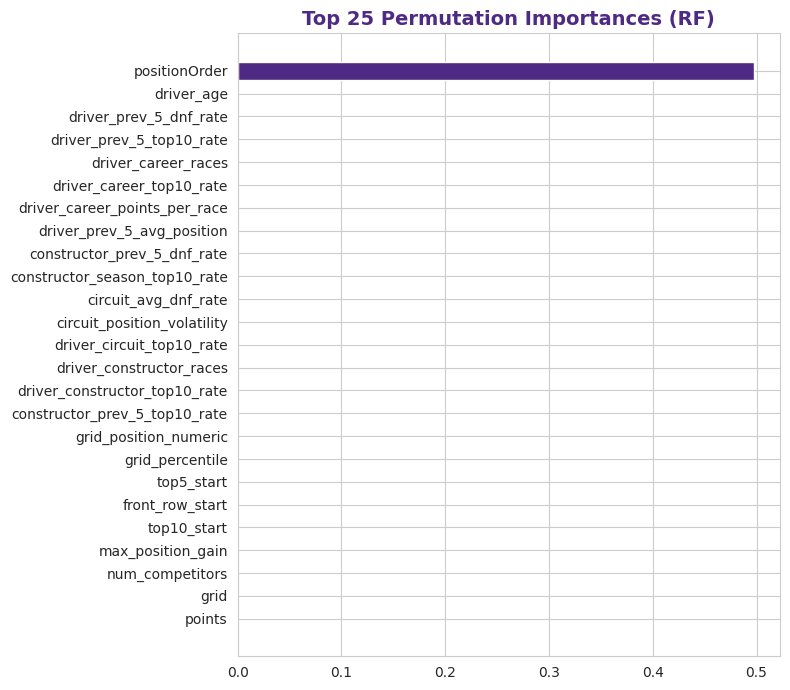

In [40]:
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=feature_cols).sort_values(ascending=False)

perm_df = perm_imp.head(25).reset_index()
perm_df.columns = ["feature", "perm_importance"]
nu_style_table(perm_df, caption="Top 25 Permutation Importances (RF on Test)")

plt.figure(figsize=(8, 7))
plt.barh(perm_df["feature"][::-1], perm_df["perm_importance"][::-1])
plt.title("Top 25 Permutation Importances (RF)")
plt.tight_layout()
plt.show()

The results from permutation importance analysis confirm what was supervised with the built-in RF importance metric: positionOrder is the primary source of predictive power, with shuffling the variable producing the greatest reduction in test performance. The positionOrder variable is basically a re-use of the same feature as the Top-10 target, since it represents the finishing order of a race. The dominance of positionOrder as a predictive feature indicates that there is target leakage, which is the probable cause for the extremely high ROC-AUC and PR-AUC values.

The remaining features in the analysis produce very small permutation effects due to the near-perfect performance of the model as well as the high correlation between many of the engineered predictors (any potential loss of information due to the shuffling of one feature can potentially be compensated for by the shuffling of another feature). Nevertheless, the ordering of the remaining features indicates that valid pre-race signals (i.e., the age and/or experience of drivers, recent driver form based on last 5 top-10 finishes including did-not-finish and constructor performance throughout the season) provide additional value beyond what is provided by positionOrder alone. In general, permutation importance analysis is a better diagnostic than in-built impurity-based importance as it clearly indicates the need to remove outcome-derived variables (such as positionOrder, points and race completion measures) from the feature set before conducting feature importance analysis for a valid pre-race prediction application.

**Reference:**  
Vopani. *Formula 1 World Championship (1950–2024).* Kaggle, 2025.